# **PART-A** 

## SVD Implementation

In [1]:
import numpy as np

def power_iteration(A, num_simulations: int = 100):
    # Random initial vector
    b_k = np.random.rand(A.shape[1])
    for _ in range(num_simulations):
        b_k1 = A @ b_k
        b_k1_norm = np.linalg.norm(b_k1)
        b_k = b_k1 / b_k1_norm
    eigenvalue = b_k @ A @ b_k
    return eigenvalue, b_k

def eig_decomposition_3x3(A):
    eigenvalues = []
    eigenvectors = []
    A_copy = np.copy(A)
    for _ in range(3):
        val, vec = power_iteration(A_copy)
        eigenvalues.append(val)
        eigenvectors.append(vec)
        # Deflation
        A_copy -= val * np.outer(vec, vec)
    return np.array(eigenvalues), np.array(eigenvectors).T  # Eigenvectors as columns

def svd_3x3(A):
    AtA = A.T @ A
    eigenvalues, V = eig_decomposition_3x3(AtA)

    # Sort by descending eigenvalue magnitude
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    V = V[:, idx]

    singular_values = np.sqrt(np.maximum(eigenvalues, 0))  # Ensure non-negative
    Sigma = np.diag(singular_values)

    # Compute U = AV Σ⁻¹
    U = A @ V
    for i in range(3):
        if singular_values[i] > 1e-10:
            U[:, i] /= singular_values[i]
        else:
            U[:, i] = 0

    return U, Sigma, V


## Kabsch Umeyama Algorithm

In [2]:
import numpy as np

def kabsch_umeyama(P, Q):
    """
    Computes the best-fit transform (rotation + translation + scale) between
    two sets of points using the Kabsch-Umeyama algorithm.
    
    Parameters:
        P (Nx3): source point cloud
        Q (Nx3): target point cloud

    Returns:
        R: rotation matrix (3x3)
        t: translation vector (3,)
        s: scale (float)
    """
    assert P.shape == Q.shape

    # Step 1: Compute centroids
    centroid_P = np.mean(P, axis=0)
    centroid_Q = np.mean(Q, axis=0)

    # Step 2: Center the points around origin
    P_centered = P - centroid_P  
    Q_centered = Q - centroid_Q

    # Step 3: Compute cross-covariance matrix H
    H = Q_centered.T @ P_centered

    # Step 4: Perform custom SVD on H
    U, S, V = svd_3x3(H)

    # Step 5: Compute rotation matrix
    R = U @ V.T

    # Step 6: Fix improper rotation (reflection case)
    if np.linalg.det(R) < 0:
        V[:, -1] *= -1
        R = U @ V.T

    # Step 7: Compute scale (optional - Umeyama adds this)
    var_P = np.sum(P_centered ** 2)
    scale = np.trace(S) / var_P

    # Step 8: Compute translation
    t = centroid_Q - scale * R @ centroid_P

    return R, t, scale

## STEP-1 LOAD DATASET AND CORRESPONDENCES

In [ ]:
import numpy as np

def load_points_from_file(file_path):
    """
    Load 3D points from a text file.
    Each line must contain three float values separated by spaces.
    """
    return np.loadtxt(file_path)


def load_correspondences(file_path):
    """
    Load correspondence indices from a text file.
    Each line contains two integers: index_in_mat1 index_in_mat2
    """
    return np.loadtxt(file_path, dtype=int)

def extract_corresponding_points(mat1, mat2, correspondences):
    """
    Given full point sets and correspondences, extract matched subsets.
    
    Returns:
        P (Nx3): points from mat1
        Q (Nx3): points from mat2
    """
    P = np.array([mat1[i] for i, _ in correspondences])
    Q = np.array([mat2[j] for _, j in correspondences])
    return P, Q


In [4]:
# Load files
mat1 = load_points_from_file("dataset1/mat1.txt")
mat2 = load_points_from_file("dataset1/mat2.txt")
correspondences = load_correspondences("dataset1/correspondences.txt")

C:\Users\birin\AppData\Local\Temp\ipykernel_10260\1400633508.py:16: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  return np.loadtxt(file_path, dtype=int)


## STEP-2 COMPUTE ROTATION MATRIX AND TRANSLATION VECTOR

In [5]:
# Extract corresponding point subsets
P, Q = extract_corresponding_points(mat1, mat2, correspondences)

# Apply Kabsch-Umeyama
R, t, s = kabsch_umeyama(P, Q)


## STEP-3 ROTATE THE 3D POINTS CLOUD

In [6]:
# Print transformation
print("Rotation Matrix:\n", R)
print("Translation Vector:\n", t)
print("Scale:\n", s)

# Optional: Transform mat2 for visualization or saving
mat1_aligned = s * (mat1 @ R.T) + t

# Save aligned points if needed
np.savetxt("mat1_aligned.txt", mat1_aligned, fmt="%.6f")

Rotation Matrix:
 [[-0.7468572  -0.38868106  0.5395659 ]
 [-0.56646154 -0.05314962 -0.82237245]
 [ 0.34831832 -0.91983811 -0.1804777 ]]
Translation Vector:
 [1.53086171 1.23273335 1.01140083]
Scale:
 1.000015890180797


### VISUALIZATION

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D projection

def plot_points_3d(P, Q, P_aligned=None, title_before="Before alignment", title_after="After alignment"):
    """
    P, Q: Nx3 numpy arrays of points
    P_aligned: Nx3 numpy array of transformed points (optional)
    """
    fig = plt.figure(figsize=(12, 6))
    
    # Before alignment
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(P[:,0], P[:,1], P[:,2], c='r', label='mat1')
    ax1.scatter(Q[:,0], Q[:,1], Q[:,2], c='b', label='mat2')
    ax1.set_title(title_before)
    ax1.legend()
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    
    # After alignment
    if P_aligned is not None:
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(P_aligned[:,0], P_aligned[:,1], P_aligned[:,2], c='r', label='mat1 aligned')
        ax2.scatter(Q[:,0], Q[:,1], Q[:,2], c='b', label='mat2')
        ax2.set_title(title_after)
        ax2.legend()
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_zlabel('Z')
    
    plt.show()


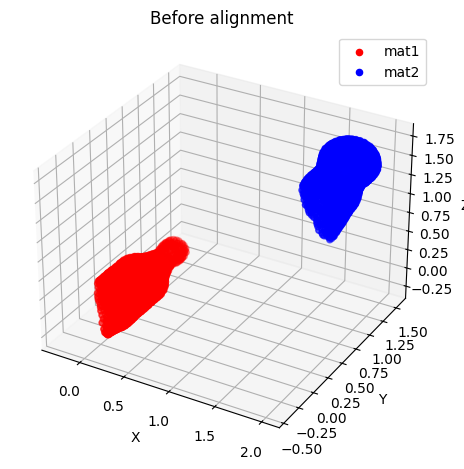

In [8]:
plot_points_3d(mat1, mat2, title_before="Before alignment")

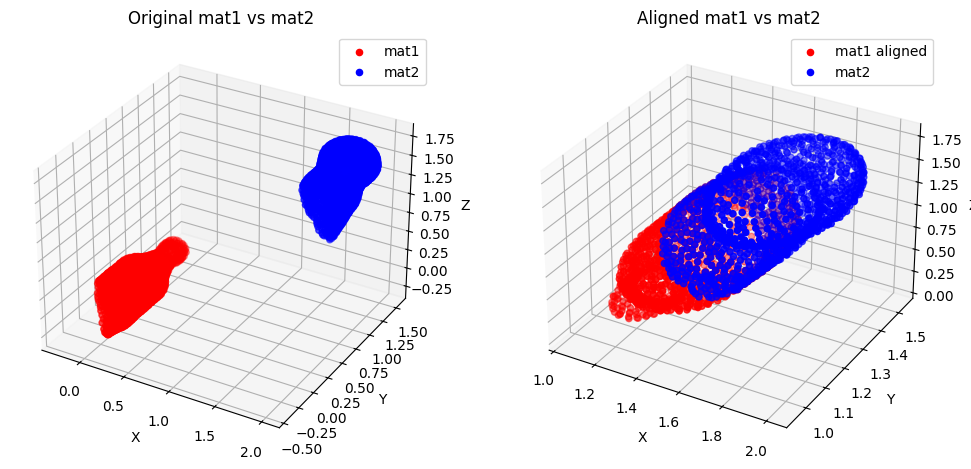

In [9]:
plot_points_3d(mat1, mat2, mat1_aligned, title_before="Original mat1 vs mat2", title_after="Aligned mat1 vs mat2")

# **PART-B**

## LOAD AND VISUALIZE FUNCTIONS

In [10]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

def load_image(image_path):
    """
    Load an image and convert it from BGR to RGB for visualization.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not read image from {image_path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def load_correspondence_points(json_path):
    """
    Load correspondence points from a JSON file and return them as two NumPy arrays.
    """
    with open(json_path, 'r') as f:
        data = json.load(f)

    points_img1 = np.array([item['img1_xy'] for item in data])
    points_img2 = np.array([item['img2_xy'] for item in data])
    
    return points_img1, points_img2

def visualize_images_with_points(img1, img2, points_img1, points_img2):
    """
    Display two images side-by-side and overlay correspondence points.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(img1)
    ax1.set_title("Image 1")
    ax1.scatter(points_img1[:, 0], points_img1[:, 1], c='red', marker='x', label='Points')
    ax1.legend()

    ax2.imshow(img2)
    ax2.set_title("Image 2")
    ax2.scatter(points_img2[:, 0], points_img2[:, 1], c='blue', marker='o', label='Points')
    ax2.legend()

    plt.tight_layout()
    plt.show()


## LOAD AND VISUALIZE THE IMAGES

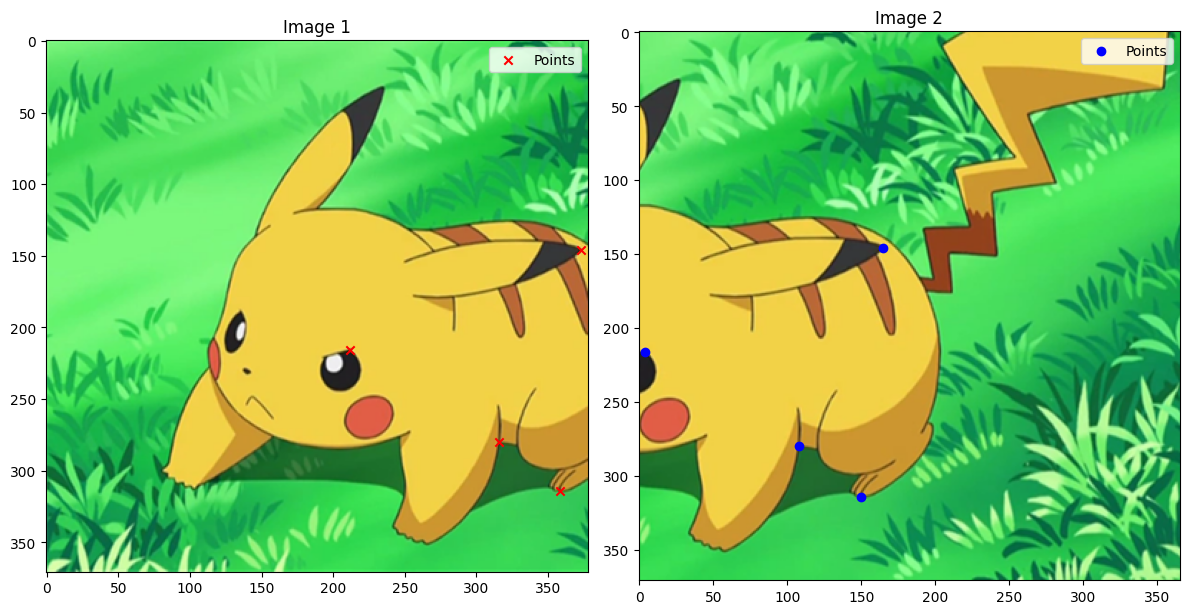

In [11]:
# --- Replace with your actual file paths ---
img1_path = "dataset2/pikachu/image1.png"
img2_path = "dataset2/pikachu/image2.png"
json_path = "dataset2/pikachu/correspondences.json"

# --- Function calls ---
img1_rgb = load_image(img1_path)
img2_rgb = load_image(img2_path)

points_img1, points_img2 = load_correspondence_points(json_path)

visualize_images_with_points(img1_rgb, img2_rgb, points_img1, points_img2)


## SVD AND KABSCH UMEYEMA IMPLEMENTATION

In [12]:
import numpy as np

def compute_centroid(points):
    return np.mean(points, axis=0)

def center_points(points, centroid):
    return points - centroid

def compute_covariance_matrix(A, B):
    return A.T @ B

def manual_svd_2x2(H):
    """
    Manually compute SVD of a 2x2 covariance matrix H using eigendecomposition.
    Only valid for 2D applications.
    """
    # Compute H^T H and H H^T
    HtH = H.T @ H
    HHt = H @ H.T

    # Eigen decomposition of H^T H => gives V and Σ²
    eigvals_V, V = np.linalg.eig(HtH)
    eigvals_U, U = np.linalg.eig(HHt)

    # Sort eigenvalues and eigenvectors in descending order
    idx_V = eigvals_V.argsort()[::-1]
    V = V[:, idx_V]
    eigvals_V = eigvals_V[idx_V]

    idx_U = eigvals_U.argsort()[::-1]
    U = U[:, idx_U]
    eigvals_U = eigvals_U[idx_U]

    # Compute singular values
    S = np.sqrt(eigvals_V)

    # Return U, S (as diag matrix), V^T
    return U, np.diag(S), V.T

def kabsch_umeyama(A, B):
    """
    Full implementation of the Kabsch-Umeyama algorithm from scratch.
    A, B: Nx2 numpy arrays of corresponding points.
    """
    assert A.shape == B.shape

    # Step 1: Compute centroids
    centroid_A = compute_centroid(A)
    centroid_B = compute_centroid(B)

    # Step 2: Center the points
    A_centered = center_points(A, centroid_A)
    B_centered = center_points(B, centroid_B)

    # Step 3: Covariance matrix
    H = A_centered.T @ B_centered

    # Step 4: Manual SVD
    U, S, Vt = manual_svd_2x2(H)

    # Step 5: Compute rotation matrix
    R = Vt.T @ U.T

    # Fix improper rotation (reflection case)
    if np.linalg.det(R) < 0:
        Vt[1, :] *= -1
        R = Vt.T @ U.T

    # Step 6: Compute scale
    var_A = np.sum(A_centered ** 2)
    scale = np.trace(S) / var_A

    # Step 7: Compute translation
    t = centroid_B - scale * R @ centroid_A

    return R, scale, t


## COMPUTE ROTATION MATRIX AND TRANSLATION VECTOR

In [13]:
# Assuming points_img1 and points_img2 are loaded as Nx2 arrays:
# (img1 = original, img2 = transformed version)

R, s, t = kabsch_umeyama(points_img1, points_img2)

print("Rotation matrix:\n", R)
print("Scale factor:", s)
print("Translation vector:", t)


Rotation matrix:
 [[ 1.00000000e+00 -9.19555691e-18]
 [-9.19555691e-18  1.00000000e+00]]
Scale factor: 1.0
Translation vector: [-2.08000000e+02  2.84217094e-14]


## STITCH IMAGES BY USING ROTATION MATRIX AND TRANSLATION

In [14]:
# Corners and transformation 

def get_corners(img):
    h, w = img.shape[:2]
    return np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32)

def transform_corners(corners, R, t):
    transformed = (R @ corners.T).T + t.reshape(1, 2)
    return transformed

# Calculate canvas size and shift 

def get_canvas_size_and_shift(img1, img2, R, t):
    corners_img1 = get_corners(img1)
    corners_img2 = get_corners(img2)
    transformed_corners_img2 = transform_corners(corners_img2, R, t)

    all_corners = np.vstack([corners_img1, transformed_corners_img2])

    min_xy = np.floor(all_corners.min(axis=0)).astype(int)
    max_xy = np.ceil(all_corners.max(axis=0)).astype(int)

    canvas_width = max_xy[0] - min_xy[0]
    canvas_height = max_xy[1] - min_xy[1]

    shift = -min_xy  # shift to positive coords

    return (canvas_width, canvas_height), shift

# Step 3: Warp images 

def warp_images(img1, img2, R, t, canvas_size, shift):
    # Shift only for img1
    shift_mat_img1 = np.array([[1, 0, shift[0]], [0, 1, shift[1]]], dtype=np.float32)
    img1_warped = cv2.warpAffine(img1, shift_mat_img1, dsize=canvas_size, flags=cv2.INTER_LINEAR, borderValue=0)

    # Compose transformation for img2: R + t + shift
    affine_img2 = np.hstack([R, t.reshape(2,1)])
    affine_img2_3x3 = np.vstack([affine_img2, [0,0,1]])

    shift_mat_3x3 = np.vstack([shift_mat_img1, [0,0,1]])

    total_transform = shift_mat_3x3 @ affine_img2_3x3
    total_transform_2x3 = total_transform[:2, :]

    img2_warped = cv2.warpAffine(img2, total_transform_2x3, dsize=canvas_size, flags=cv2.INTER_LINEAR, borderValue=0)

    return img1_warped, img2_warped

# Step 4: Simple blending (replace where img2 has data) 

def simple_blend(img1_warped, img2_warped):
    mask = img2_warped > 0
    blended = img1_warped.copy()
    blended[mask] = img2_warped[mask]
    return blended

# Step 5: Visualization 

def visualize_images(images, titles):
    n = len(images)
    plt.figure(figsize=(10 * n, 10))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.figure(figsize=(10 * n, 10))
        plt.subplot(1, n, i+1)
        if len(img.shape) == 2:  # grayscale
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
        plt.show()

# --- Main stitching pipeline ---

def stitch_images(img1, img2, R, t):
    canvas_size, shift = get_canvas_size_and_shift(img1, img2, R, t)
    img1_warped, img2_warped = warp_images(img1, img2, R, t, canvas_size, shift)
    stitched = simple_blend(img1_warped, img2_warped)
    
    visualize_images(
        [img1, img2, img1_warped, img2_warped, stitched],
        ['Image 1 (Left)', 'Image 2 (Right)', 'Warped Image 1', 'Warped Image 2', 'Stitched Result']
    )
    
    return stitched

## STITCH IMAGES

<Figure size 5000x1000 with 0 Axes>

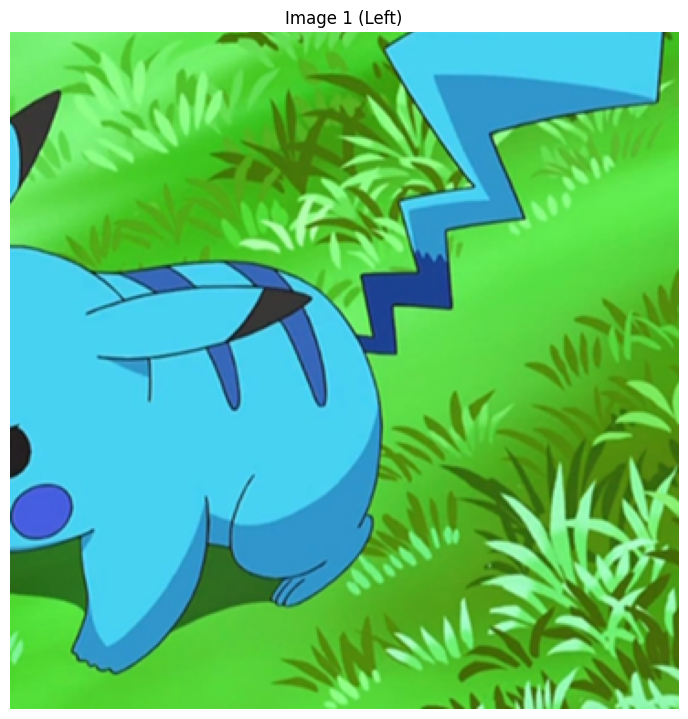

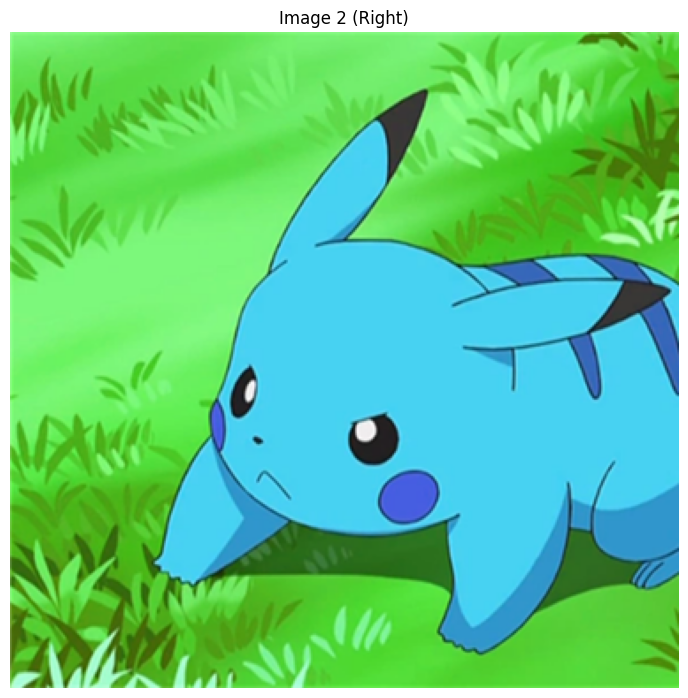

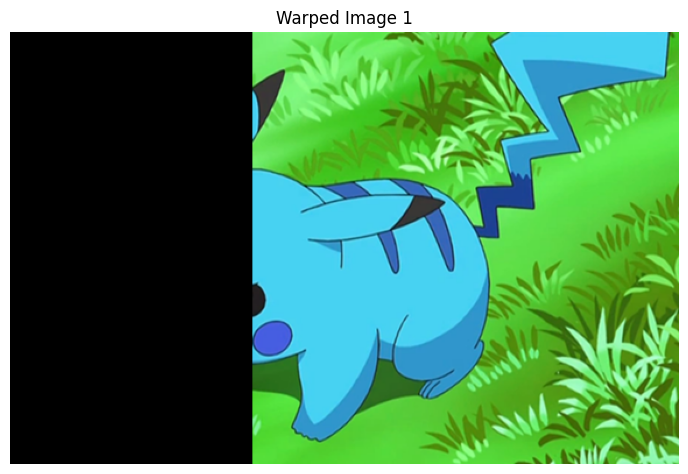

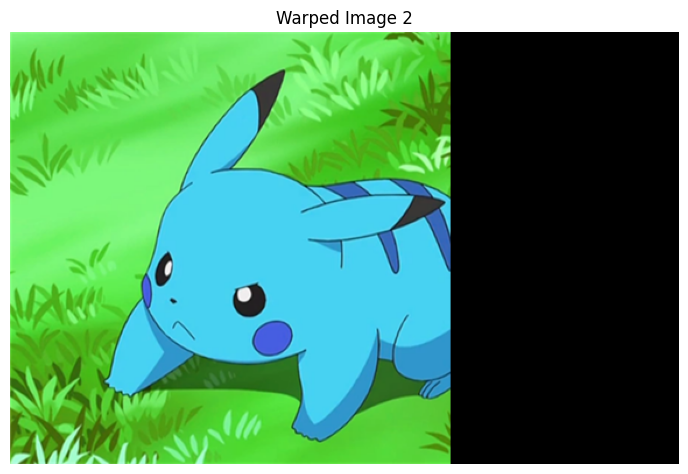

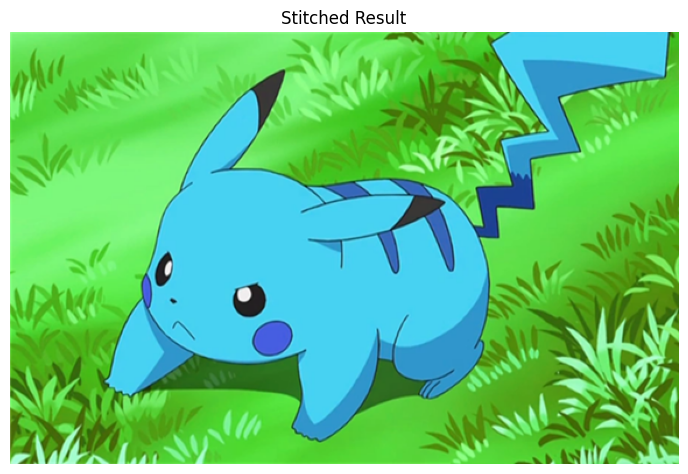

In [15]:
stitched_image = stitch_images(img2_rgb, img1_rgb, R, t)

## OTHER IMAGES

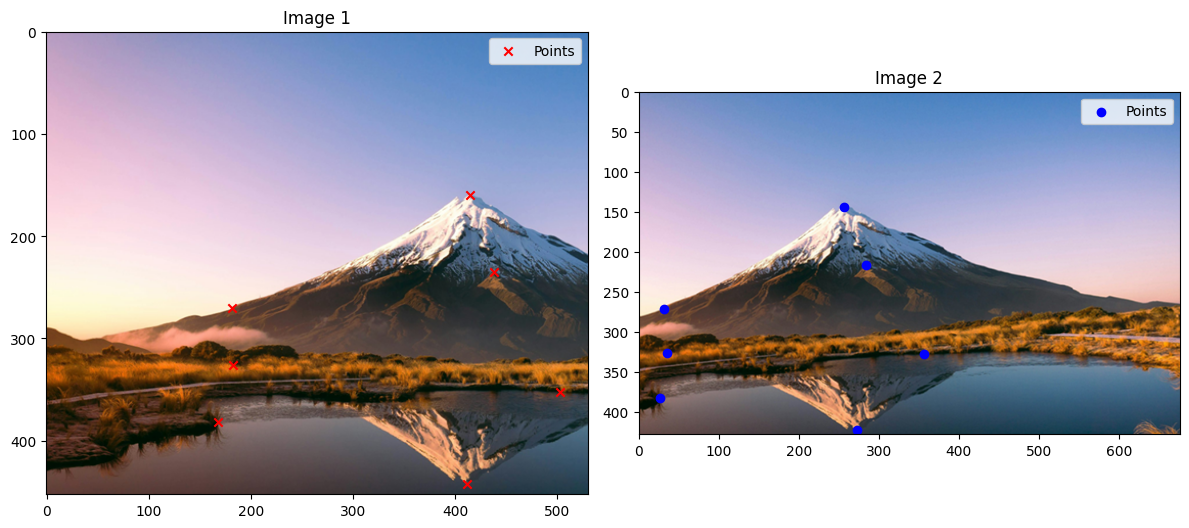

In [16]:
# --- Replace with your actual file paths ---
img1_path = "dataset2/mountain/image1.png"
img2_path = "dataset2/mountain/image2.png"
json_path = "dataset2/mountain/correspondences.json"

# --- Function calls ---
img1_rgb = load_image(img1_path)
img2_rgb = load_image(img2_path)

points_img1, points_img2 = load_correspondence_points(json_path)

visualize_images_with_points(img1_rgb, img2_rgb, points_img1, points_img2)


In [17]:
R, s, t = kabsch_umeyama(points_img1, points_img2)

print("Rotation matrix:\n", R)
print("Scale factor:", s)
print("Translation vector:", t)


Rotation matrix:
 [[ 0.99727742  0.07374102]
 [-0.07374102  0.99727742]]
Scale factor: 0.9979867443764949
Translation vector: [-169.37210443   14.62376663]


<Figure size 5000x1000 with 0 Axes>

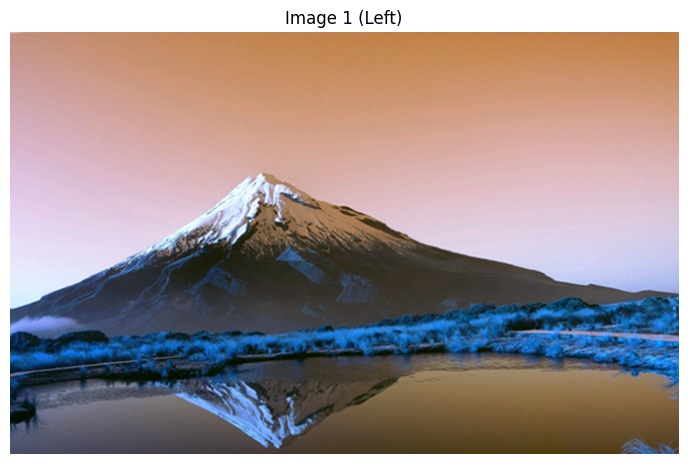

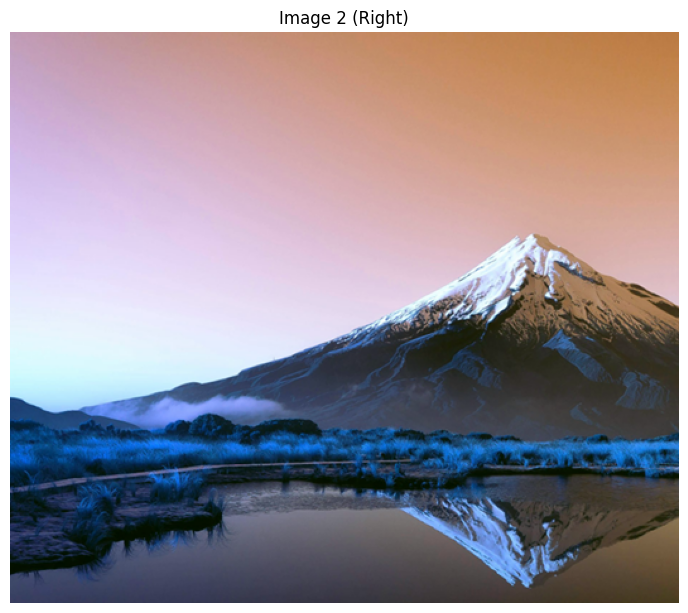

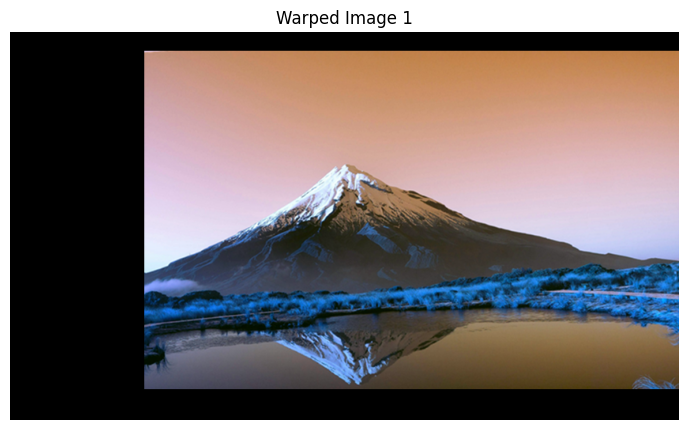

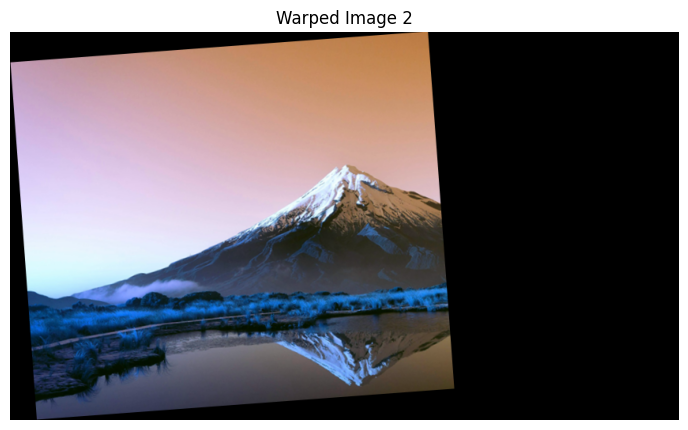

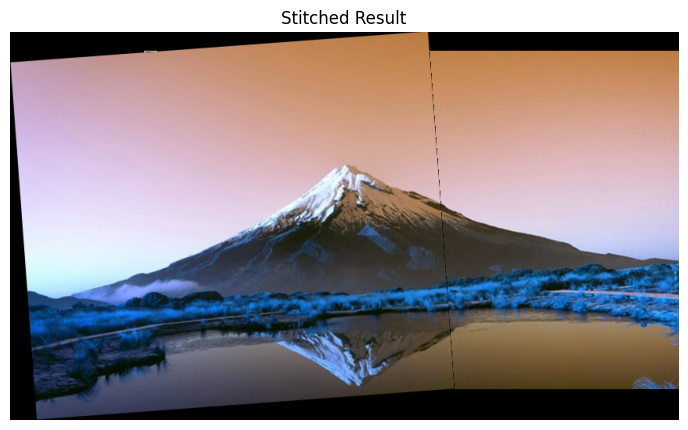

In [18]:
stitched_image = stitch_images(img2_rgb, img1_rgb, R, t)

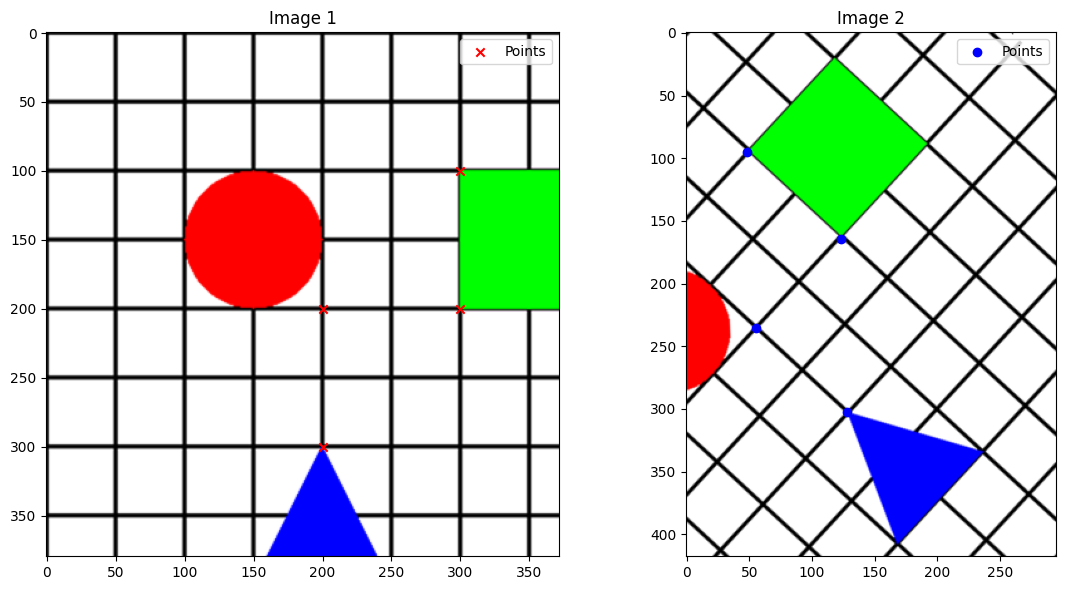

In [19]:
# --- Replace with your actual file paths ---
img1_path = "dataset2/grid/image1.png"
img2_path = "dataset2/grid/image2.png"
json_path = "dataset2/grid/correspondences.json"

# --- Function calls ---
img1_rgb = load_image(img1_path)
img2_rgb = load_image(img2_path)

points_img1, points_img2 = load_correspondence_points(json_path)

visualize_images_with_points(img1_rgb, img2_rgb, points_img1, points_img2)


In [20]:
R, s, t = kabsch_umeyama(points_img1, points_img2)

print("Rotation matrix:\n", R)
print("Scale factor:", s)
print("Translation vector:", t)


Rotation matrix:
 [[ 0.67618151  0.73673507]
 [-0.73673507  0.67618151]]
Scale factor: 0.9908582138732055
Translation vector: [-225.   247.5]


<Figure size 5000x1000 with 0 Axes>

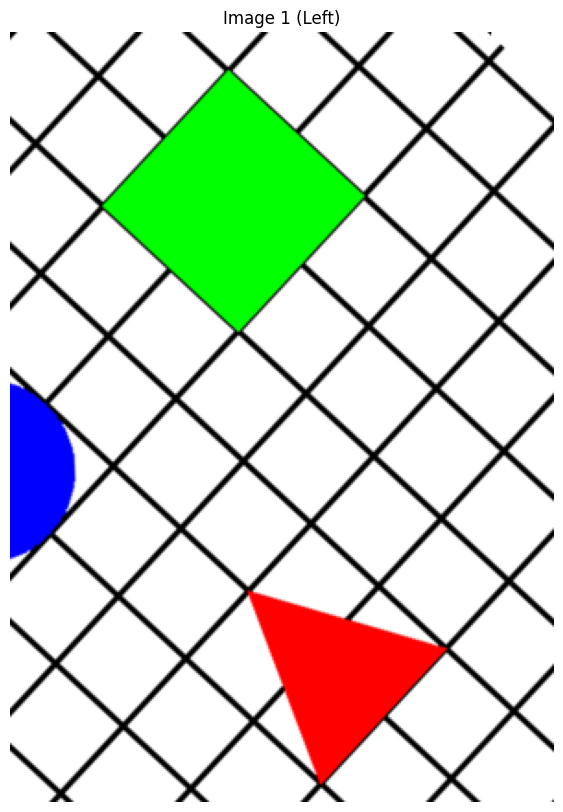

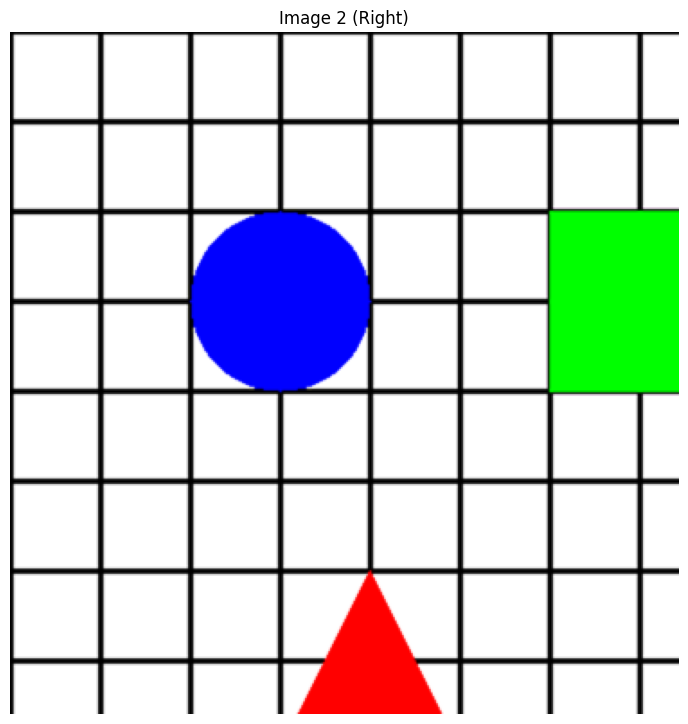

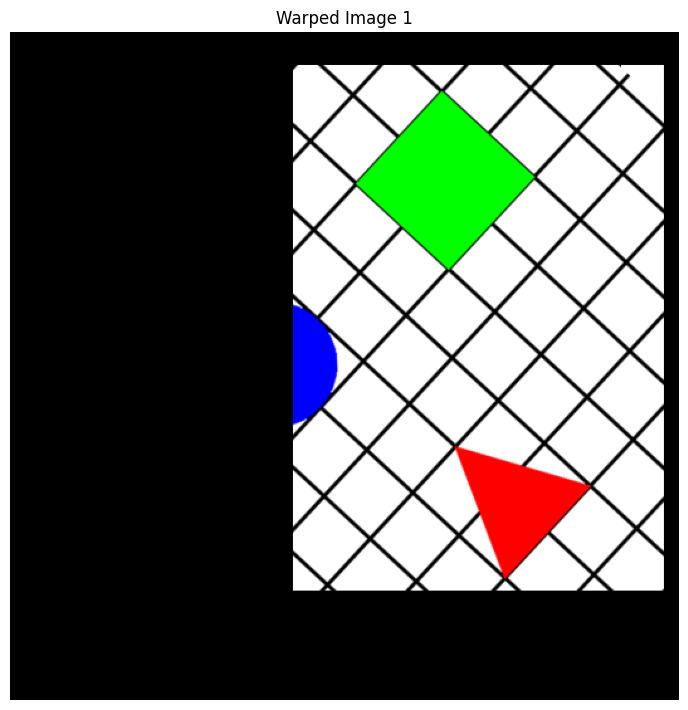

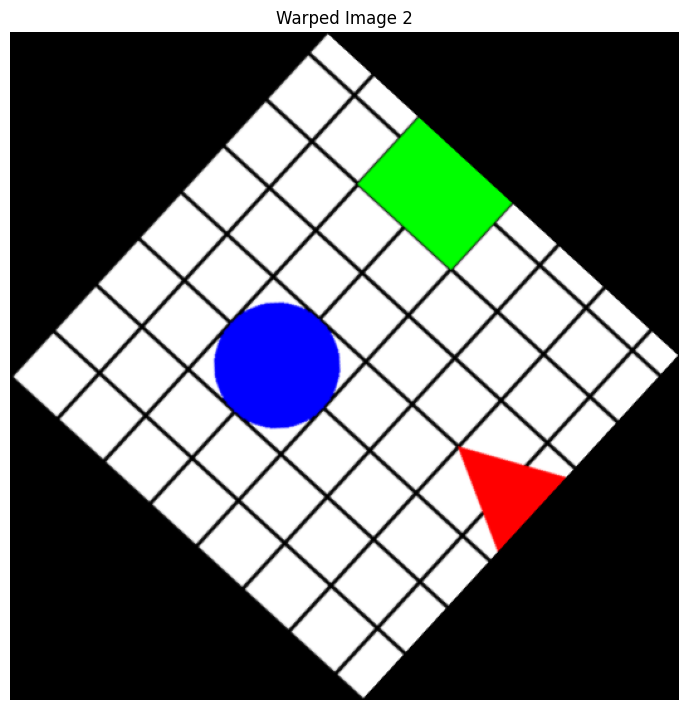

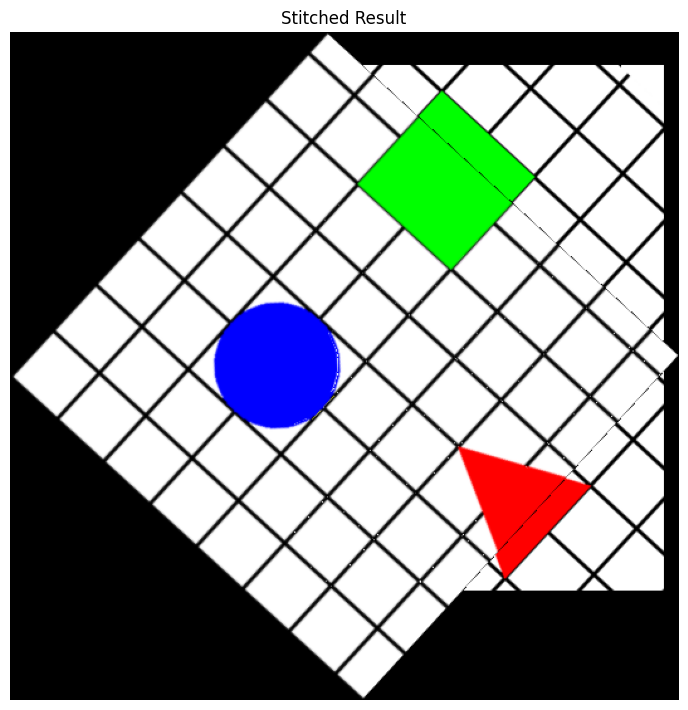

In [21]:
stitched_image = stitch_images(img2_rgb, img1_rgb, R, t)

## BONUS-1 

### Bonus Section Explanation

This section demonstrates the use of the Kabsch-Umeyama algorithm on real images captured using my own camera. The goal is to stitch image pairs by estimating the rigid transformation (rotation and translation) between overlapping regions.

> **Note:** Since the images used here are locally stored and not included in this submission, you will not be able to run the following cells directly. However, you can still examine the outputs and results provided below to understand how the algorithm performed on real-world data.

The stitched images illustrate that even with small viewpoint changes and slight camera tilts, the algorithm can successfully align the image fragments using only rigid transformations.


In [ ]:
# --- Replace with your actual file paths ---
# img1_path = "dataset2/yurt/left.jpg"
# img2_path = "dataset2/yurt/right.jpg"
# json_path = "dataset2/yurt/correspondences.json"

# # --- Function calls ---
# img1_rgb = load_image(img1_path)
# img2_rgb = load_image(img2_path)

# points_img1, points_img2 = load_correspondence_points(json_path)

# visualize_images_with_points(img1_rgb, img2_rgb, points_img1, points_img2)


In [ ]:
# R, s, t = kabsch_umeyama(points_img1, points_img2)

# print("Rotation matrix:\n", R)
# print("Scale factor:", s)
# print("Translation vector:", t)


Rotation matrix:
 [[ 0.99977657 -0.02113791]
 [ 0.02113791  0.99977657]]
Scale factor: 1.0352457457326216
Translation vector: [-204.21563555  -45.4784765 ]


In [ ]:
# stitched_image = stitch_images(img2_rgb, img1_rgb, R, t)